In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as sk
import pandas as pd

import keijzer_exogan as ke

from tqdm import tqdm
# initialize random seeds
manualSeed = 999
np.random.seed(manualSeed)

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks')

In [2]:
randn = np.random.randn(10**4, 10**4)
randn.shape

(10000, 10000)

Mean1: 0.004 	 std1: 1.004
Mean2: -0.006 	 std2: 0.992


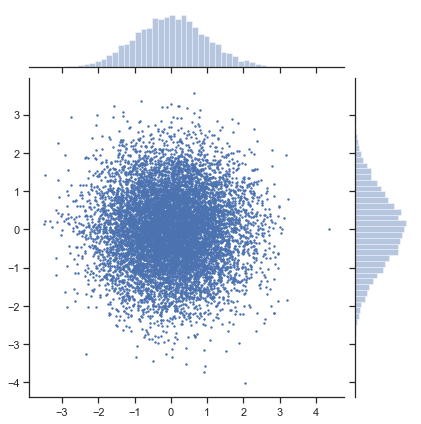

In [3]:
_ = sns.jointplot(randn[0], randn[1], s=2)

mean1, std1 = randn[0].mean(), randn[0].std()
mean2, std2 = randn[1].mean(), randn[1].std()

print('Mean1: {:.3f} \t std1: {:.3f}'.format(mean1, std1))
print('Mean2: {:.3f} \t std2: {:.3f}'.format(mean2, std2))

In [4]:
#scaler = sk.preprocessing.RobustScaler()
#scaler = sk.preprocessing.QuantileTransformer(output_distribution='normal') # output_distribution='uniform'
scaler = sk.preprocessing.RobustScaler()
randn[0].reshape(-1, 1).shape

(10000, 1)

In [5]:
scaler1 = scaler.fit(randn[0].reshape(-1,1))
scaler1

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [6]:
transformed1 = scaler1.transform(randn[0].reshape(-1,1))

Mean1: 0.004 	 std1: 1.004
Mean2: -0.006 	 std2: 0.992


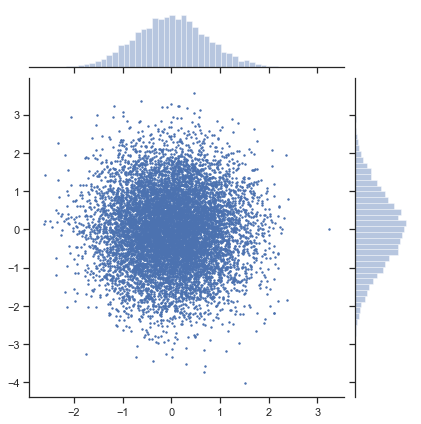

In [7]:
_ = sns.jointplot(transformed1.flatten(), randn[1], s=2)

mean1, std1 = randn[0].mean(), randn[0].std()
mean2, std2 = randn[1].mean(), randn[1].std()

print('Mean1: {:.3f} \t std1: {:.3f}'.format(mean1, std1))
print('Mean2: {:.3f} \t std2: {:.3f}'.format(mean2, std2))

In [8]:
# could use: import pickle... however let's do something else
from sklearn.externals import joblib 

# this is more efficient than pickle for things like large numpy arrays
# ... which sklearn models often have.   

# then just 'dump' your file
joblib.dump(scaler1, 'scaler1.pkl') 

['scaler1.pkl']

In [9]:
scaler2 = joblib.load('scaler1.pkl') 

Mean1: 0.004 	 std1: 1.004
Mean2: -0.006 	 std2: 0.992


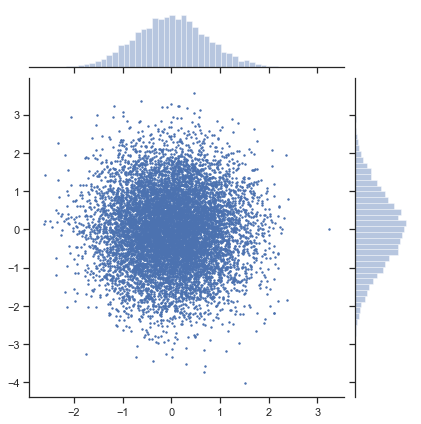

In [10]:
transformed2 = scaler2.transform(randn[0].reshape(-1,1))

_ = sns.jointplot(transformed2.flatten(), randn[1], s=2)

mean1, std1 = randn[0].mean(), randn[0].std()
mean2, std2 = randn[1].mean(), randn[1].std()

print('Mean1: {:.3f} \t std1: {:.3f}'.format(mean1, std1))
print('Mean2: {:.3f} \t std2: {:.3f}'.format(mean2, std2))

Mean1: 0.004 	 std1: 1.004
Mean2: -0.006 	 std2: 0.992


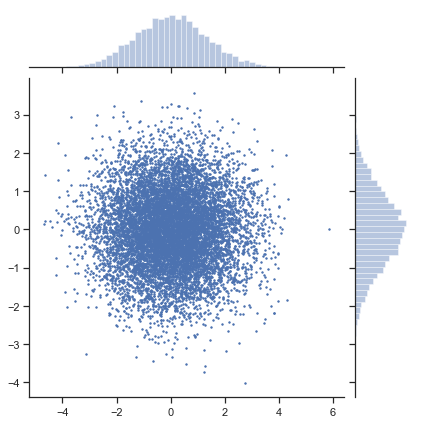

In [11]:
transformed2 = scaler2.inverse_transform(randn[0].reshape(-1,1))

_ = sns.jointplot(transformed2.flatten(), randn[1], s=2)

mean1, std1 = randn[0].mean(), randn[0].std()
mean2, std2 = randn[1].mean(), randn[1].std()

print('Mean1: {:.3f} \t std1: {:.3f}'.format(mean1, std1))
print('Mean2: {:.3f} \t std2: {:.3f}'.format(mean2, std2))

# Fit stuff on train data

In [12]:
path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...

In [15]:
X = np.load(path+'test_chunks.npy', allow_pickle=True)
wavelengths = pd.read_csv(path+'wnw_grid.txt', header=None).values
len(X), X.shape

(10000, (10000,))

In [16]:
df = pd.read_csv('wavelengths_and_indices.csv', header=None, skiprows=[0], usecols=[1]) # load wavelengths
df.columns = ['x']
df = df.loc[df['x'] <= 16] # select only wavelengths <= 16

x = X[0]

def get_bins(x):
    """
    Code taken from def ASPA_v3(x, wavelengths, max_wavelength=16): 
    
    x = input dict
    returns list of dataframes (from the bins) with x being wavelength values, y being R/R values
    """
    spectrum = x['data']['spectrum']
    
    #print('Original spectrum length: ', len(spectrum))
    spectrum = np.expand_dims(spectrum, axis=1) # change shape from (515,) to (515,1)
    params = x['param']

    data = np.concatenate([wavelengths,spectrum], axis=1)
    #print('Original data length: ', len(data))
    data = pd.DataFrame(data)
    data.columns = ['x', 'y'] # x is wavelength, y is (R_p / R_s)^2
    data = data.loc[data['x'] <= 16] # select only wavelengths <= 16

    # Could loop this, but right now this is more visual
    bin1 = data[data.x <= 0.8]
    bin2 = data[(data.x > 0.8) & (data.x <= 1.3)] # select data between 2 and 4 micron
    bin3 = data[(data.x > 1.3) & (data.x <= 2)]
    bin4 = data[(data.x > 2) & (data.x <= 4)]
    bin5 = data[(data.x > 4) & (data.x <= 6)]
    bin6 = data[(data.x > 6) & (data.x <= 10)]
    bin7 = data[(data.x > 10) & (data.x <= 14)]
    bin8 = data[data.x > 14]

    bins = [bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]
    

    scalers = [sk.preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(b) for b in bins] # list of 8 scalers for the 8 bins
    mins = [ b.iloc[:,1].min() for b in bins] # .iloc[:,1] selects the R/R (y) only
    maxs = [ b.iloc[:,1].max() for b in bins]
    stds = [ b.iloc[:,1].std() for b in bins]
    #print(min(mins), max(maxs))
    bins_scaled = []
    for i,b in enumerate(bins):
        bins_scaled.append(scalers[i].transform(b))
        
    spectrum_scaled = np.concatenate(bins_scaled, axis=0)
    spectrum_scaled = spectrum_scaled[:,1]
    #print('spectrum scaled shape: ', spectrum_scaled.shape)
    
    return bins_scaled

In [17]:
def bins_list_to_np(bins_list):
    """
    Convert y values from bins list to np array
    """
    bins = [np.array(bin_) for bin_ in bins_list]
    return bins

In [18]:
all_bins_list = [bins_list_to_np(get_bins(x)) for x in tqdm(X[:1000])]

100%|██████████| 1000/1000 [00:17<00:00, 59.92it/s]


In [19]:
len(all_bins_list)

1000

In [20]:
len(all_bins_list[0])

8

In [21]:
len(all_bins_list[0][0])

14

In [22]:
# create list of bins1 ... bins8 where bins1 contains all values from all bin1's

all_bins = []
for bin_ in range(8):
    all_bins.append(np.array([all_bins_list[i][bin_] for i in range(len(all_bins_list))]))

In [23]:
all_bins[0].shape

(1000, 14, 2)

CPU times: user 578 ms, sys: 192 ms, total: 770 ms
Wall time: 578 ms


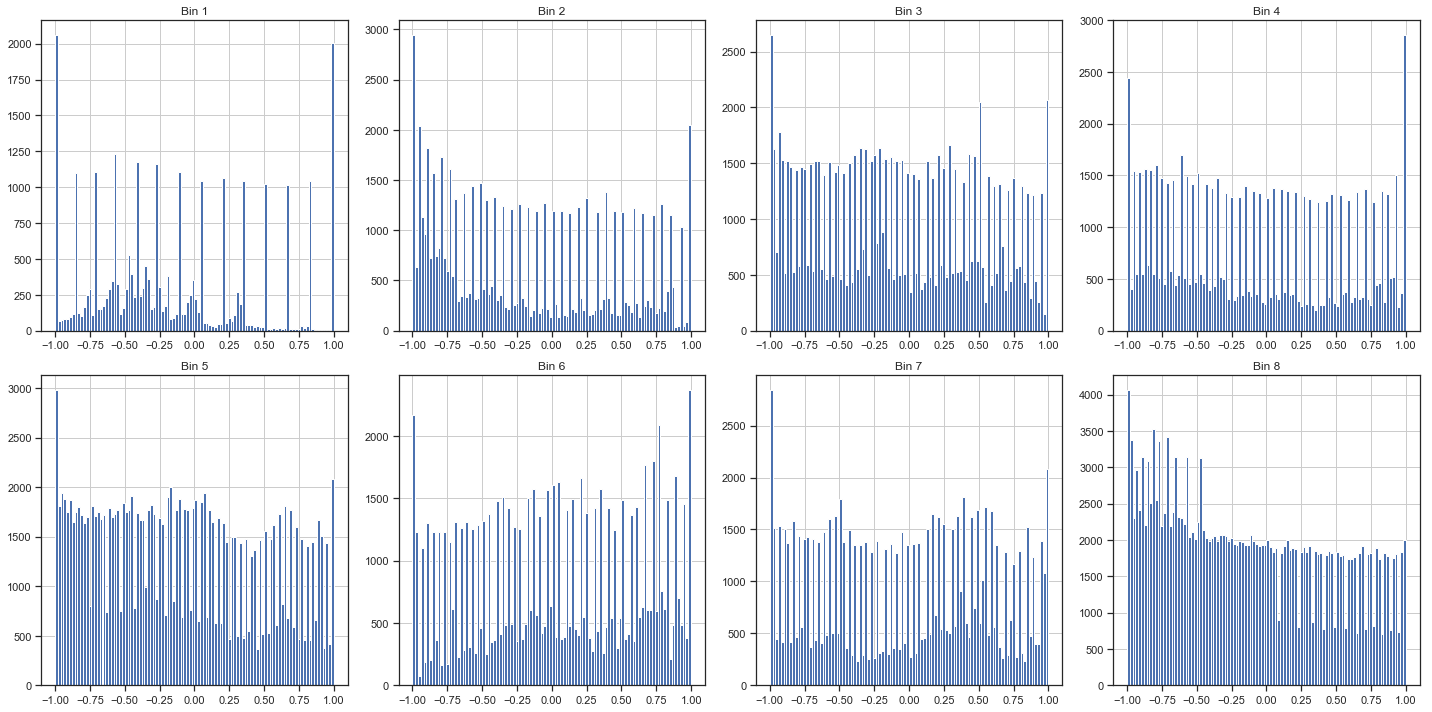

In [24]:
%%time
plt.figure(figsize=(20,10))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title('Bin %s' % (i+1))
    plt.hist(all_bins[i].flatten(), bins=100)
    plt.grid()
    
plt.tight_layout()

CPU times: user 48.4 ms, sys: 6.63 ms, total: 55 ms
Wall time: 52.2 ms


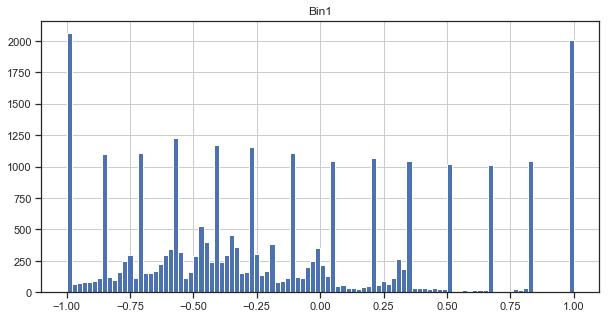

In [25]:
%%time
plt.figure(figsize=(10,5))
plt.title('Bin1')
_ = plt.hist(all_bins[0].flatten(), bins=100)
plt.grid()

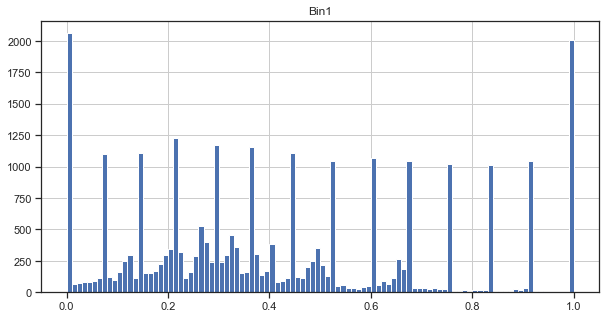

In [26]:
scaler = sk.preprocessing.MinMaxScaler()
x = all_bins[0].flatten()

scaler1 = scaler.fit(x.reshape(-1,1))
x_transformed = scaler1.transform(x.reshape(-1,1))

plt.figure(figsize=(10,5))
plt.title('Bin1')
_ = plt.hist(x_transformed.flatten(), bins=100)
plt.grid()

Mean: -0.087 	 std: 0.594 	 min: -1.00000 	 max: 1.00000


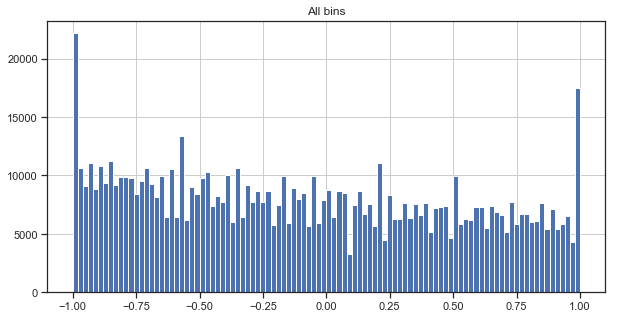

In [27]:
t = np.array([all_bins[j].flatten().reshape(-1,1) for j in range(8)])

t = np.concatenate([t[i] for i in range(8)])

plt.figure(figsize=(10,5))
plt.title('All bins')
_ = plt.hist(t.flatten(), bins=100)
plt.grid()

print('Mean: {:.3f} \t std: {:.3f} \t min: {:.5f} \t max: {:.5f}'.format(t.mean(), t.std(), t.min(), t.max()))

It's possibly a problem that dataset isn't uniformly distributed when each spectrum is scaled individually...

Options:  
Select bins like exogan -> water bins + more bins than 8  (Try this first)
Different scaler  

In [28]:
# Hist per pixel

%%time
plt.figure(figsize=(20,10))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title('Bin %s' % (i+1))
    plt.hist(all_bins[i].flatten(), bins=100)
    plt.grid()
    
plt.tight_layout()

SyntaxError: invalid syntax (<ipython-input-28-c8180db65e4b>, line 3)